In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pandas.plotting import scatter_matrix

## Data preparation

### Import data

In [2]:
data = pd.read_csv("/kaggle/input/d/rabieelkharoua/students-performance-dataset/Student_performance_data _.csv")
data.head(10)

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0
5,1006,18,0,0,1,8.191219,0,0,1,1,0,0,0,3.084184,1.0
6,1007,15,0,1,1,15.601680,10,0,3,0,1,0,0,2.748237,2.0
7,1008,15,1,1,4,15.424496,22,1,1,1,0,0,0,1.360143,4.0
8,1009,17,0,0,0,4.562008,1,0,2,0,1,0,1,2.896819,2.0
9,1010,16,1,0,1,18.444466,0,0,3,1,0,0,0,3.573474,0.0


In [3]:
del data['StudentID']

### Missing values

In [4]:
data.isnull().sum()

Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

There are no missing values

### Duplication

In [5]:
sum(data.duplicated())

0

There are no duplicated rows

### Change data types

In [6]:
data.nunique()

Age                     4
Gender                  2
Ethnicity               4
ParentalEducation       5
StudyTimeWeekly      2392
Absences               30
Tutoring                2
ParentalSupport         5
Extracurricular         2
Sports                  2
Music                   2
Volunteering            2
GPA                  2371
GradeClass              5
dtype: int64

In [7]:
data['Age'] = data['Age'].astype('category')
data['Ethnicity'] = data['Ethnicity'].astype('category')
data['ParentalEducation'] = data['ParentalEducation'].astype('category')
data['ParentalSupport'] = data['ParentalSupport'].astype('category')
data['GradeClass'] = data['GradeClass'].astype('category')

data['Gender'] = data['Gender'].astype(bool)
data['Tutoring'] = data['Tutoring'].astype(bool)
data['Extracurricular'] = data['Extracurricular'].astype(bool)
data['Sports'] = data['Sports'].astype(bool)
data['Music'] = data['Music'].astype(bool)
data['Volunteering'] = data['Volunteering'].astype(bool)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                2392 non-null   category
 1   Gender             2392 non-null   bool    
 2   Ethnicity          2392 non-null   category
 3   ParentalEducation  2392 non-null   category
 4   StudyTimeWeekly    2392 non-null   float64 
 5   Absences           2392 non-null   int64   
 6   Tutoring           2392 non-null   bool    
 7   ParentalSupport    2392 non-null   category
 8   Extracurricular    2392 non-null   bool    
 9   Sports             2392 non-null   bool    
 10  Music              2392 non-null   bool    
 11  Volunteering       2392 non-null   bool    
 12  GPA                2392 non-null   float64 
 13  GradeClass         2392 non-null   category
dtypes: bool(6), category(5), float64(2), int64(1)
memory usage: 82.9 KB


## Exploratory Data Analysis

### Basic statistics

In [9]:
data.describe()

,StudyTimeWeekly,Absences,GPA
count,2392.000000,2392.000000,2392.000000
mean,9.771992,14.541388,1.906186
std,5.652774,8.467417,0.915156
min,0.001057,0.000000,0.000000
25%,5.043079,7.000000,1.174803
50%,9.705363,15.000000,1.893393
75%,14.408410,22.000000,2.622216
max,19.978094,29.000000,4.000000


### Visualization

In [10]:
sns.set_palette('pastel')

In [11]:
num_cols = data.select_dtypes(include=['int64','float64']).columns
cat_cols = data.select_dtypes(include=['category', 'bool']).columns

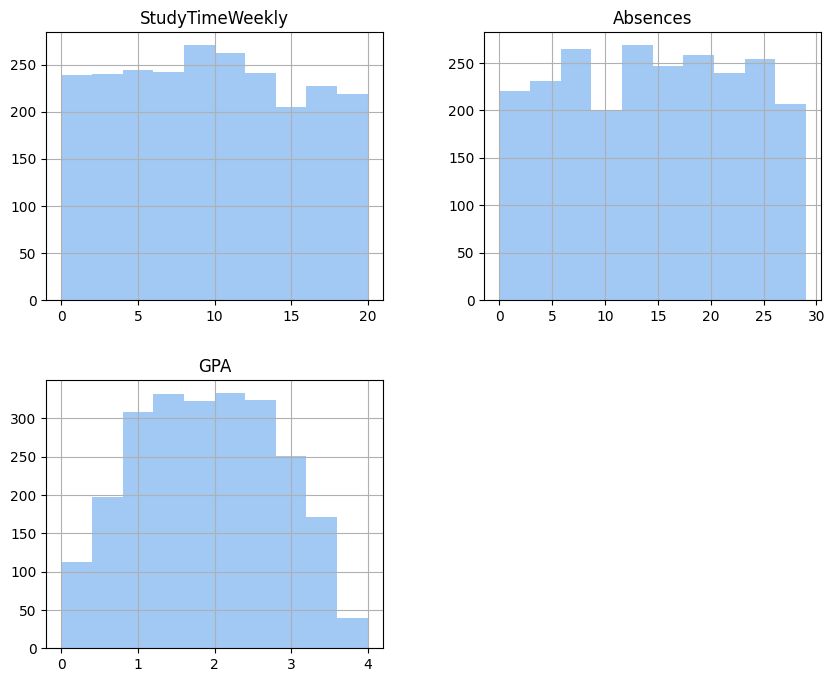

In [12]:
data[num_cols].hist(figsize = (10,8))
plt.show()

In [13]:
corr_matrix = data[num_cols].corr()
corr_matrix.style.background_gradient(cmap = 'coolwarm').format(precision = 3)

,StudyTimeWeekly,Absences,GPA
StudyTimeWeekly,1.000,0.009,0.179
Absences,0.009,1.000,-0.919
GPA,0.179,-0.919,1.000


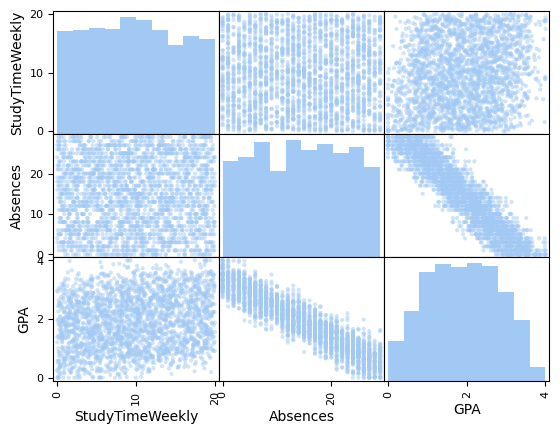

In [14]:
scatter_matrix(data[num_cols])
plt.show()

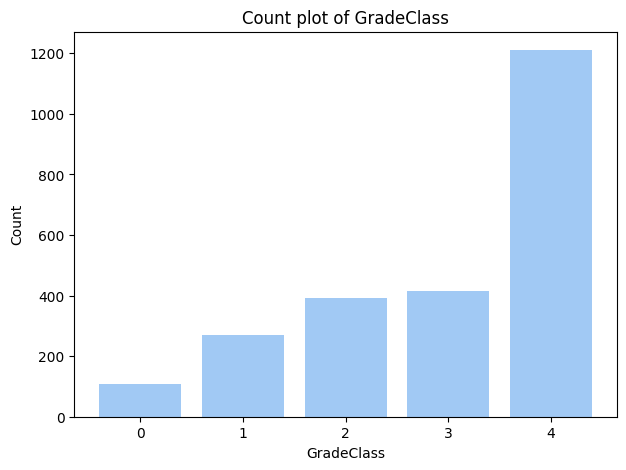

In [15]:
grade_counts = data['GradeClass'].value_counts()

plt.figure(figsize=(7,5))
plt.bar(grade_counts.index, grade_counts)
plt.xlabel('GradeClass')
plt.ylabel('Count')
plt.title('Count plot of GradeClass')
plt.show()